# Face Clustering Visualization and Explainability Analysis

This notebook provides interactive visualizations of clustering results and explainability analysis using SHAP and LIME.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import cv2
import pickle
import shap
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

## Load Data and Models

Load the clustering results, PCA model, and scaler for face reconstruction.

In [2]:
df = pd.read_csv('final_clustering.csv')

model_path = 'pca_scaler_model.pickle'

try:
    with open(model_path, 'rb') as f:
        loaded_data = pickle.load(f)
        
    scaler = loaded_data['scaler']
    pca = loaded_data['pca']
    
    print("Successfully loaded 'pca_scaler_model.pickle'")
    print(f"   - Components: {pca.n_components_}")
    
except FileNotFoundError:
    print(f"Error: Could not find '{model_path}'. Please check the file path.")
    raise

Successfully loaded 'pca_scaler_model.pickle'
   - Components: 248


## Define Principal Component Columns

In [3]:
pc_columns = [f'PC_{i}' for i in range(1, pca.n_components_ + 1)]

## Interactive 3D Plot Function

This function creates an interactive 3D scatter plot with face reconstruction on click. Each point represents a face sample colored by its cluster assignment.

In [6]:
def create_interactive_plot(dataframe, cluster_column, method_name, pc_cols_list, pca_model, scaler_model, color_theme='Viridis'):
    
    trace = go.Scatter3d(
        x=dataframe['PC_1'],
        y=dataframe['PC_2'],
        z=dataframe['PC_3'],
        mode='markers',
        marker=dict(
            size=4,
            color=dataframe[cluster_column],
            colorscale=color_theme,
            opacity=0.8,
            colorbar=dict(title='Cluster ID')
        ),
        text=dataframe['person_name'],
        hoverinfo='text'
    )

    layout = go.Layout(
        title=f'3D Visualization: {method_name}',
        scene=dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=600
    )

    fig = go.FigureWidget(data=[trace], layout=layout)

    image_widget = widgets.Image(
        format='png',
        width=300,
        height=300,
        value=b''
    )
    
    output_label = widgets.Label(value="Click a point to reconstruct the face.")

    def update_image(trace, points, selector):
        if not points.point_inds:
            return
            
        idx = points.point_inds[0]
        
        try:
            pca_features = dataframe.iloc[idx][pc_cols_list].values.reshape(1, -1)
            reconstructed_scaled = pca_model.inverse_transform(pca_features)
            reconstructed_pixels = scaler_model.inverse_transform(reconstructed_scaled)
            img_array = np.clip(reconstructed_pixels.reshape(250, 250), 0, 255).astype(np.uint8)
            
            _, encoded_img = cv2.imencode('.png', img_array)
            image_widget.value = encoded_img.tobytes()
            
            name = dataframe.iloc[idx]['person_name']
            cluster = dataframe.iloc[idx][cluster_column]
            output_label.value = f"Name: {name} | Cluster: {cluster}"
            
        except Exception as e:
            output_label.value = f"Error: {str(e)}"

    fig.data[0].on_click(update_image)

    return widgets.HBox([fig, widgets.VBox([output_label, image_widget])])

## Interactive Clustering Visualizations

Below we create five different 3D visualizations, each representing a different clustering method applied to the face dataset. Each tab uses a unique color theme to distinguish the clusters:

| Tab | Clustering Method | Color Theme |
|-----|-------------------|-------------|
| K-Means | Centroid-based partitioning | Viridis (Green/Purple) |
| SOM | Self-Organizing Maps | Plasma (Blue/Red/Yellow) |
| Hierarchical | Agglomerative clustering | Turbo (Rainbow) |
| DBSCAN | Density-based clustering | Inferno (Black/Red/Yellow) |
| Face Groups | Face similarity groupings | Cividis (Blue/Yellow/Grey) |

**Interactive Features:**
- Rotate, zoom, and pan the 3D scatter plot
- Hover over points to see person names
- Click on any point to reconstruct and display the face image

In [7]:
tab1 = create_interactive_plot(df, 'kmeans_cluster', 'K-Means Clustering', pc_columns, pca, scaler, color_theme='Viridis')
tab2 = create_interactive_plot(df, 'som_cluster', 'SOM (Bonus)', pc_columns, pca, scaler, color_theme='Plasma')
tab3 = create_interactive_plot(df, 'hierarchical_cluster', 'Hierarchical Clustering', pc_columns, pca, scaler, color_theme='Turbo')
tab4 = create_interactive_plot(df, 'dbscan_cluster', 'DBSCAN (Density Based)', pc_columns, pca, scaler, color_theme='Inferno')
tab5 = create_interactive_plot(df, 'face_group', 'Face Similarity Groups', pc_columns, pca, scaler, color_theme='Cividis')

tabs = widgets.Tab(children=[tab1, tab2, tab3, tab4, tab5])
tabs.set_title(0, 'K-Means')
tabs.set_title(1, 'SOM')
tabs.set_title(2, 'Hierarchical')
tabs.set_title(3, 'DBSCAN')
tabs.set_title(4, 'Face Groups')

display(tabs)

    'data': [{'hoverinfo': 'text',
              'marker': {'color…

---
# Explainability Analysis

Using surrogate models (Random Forest) to understand which principal components drive the clustering decisions.

In [43]:
labels_df = pd.read_csv('all_clustering_labels.csv')
pca_df = pd.read_csv('pca_features_variance.csv')

## Prepare Features and Labels

Extract PCA features and clustering labels for training surrogate models.

In [44]:
labels = labels_df.drop(columns=['person_name'])
pca_features = pca_df.drop(columns=['person_name'])

X = pca_features.values
feature_names = pca_features.columns.tolist()

## Train Surrogate Models

Train Random Forest classifiers to approximate each clustering method. These surrogate models allow us to apply interpretability techniques like SHAP and LIME.

In [45]:
surrogate_models = {}
clustering_methods = ['kmeans_cluster', 'som_cluster', 'hierarchical_cluster', 'dbscan_cluster']

for method in clustering_methods:
    y = labels[method].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    accuracy = rf.score(X_test, y_test)
    surrogate_models[method] = {'model': rf, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'accuracy': accuracy}
    print(f"{method}: Surrogate model accuracy = {accuracy:.4f}")

kmeans_cluster: Surrogate model accuracy = 0.8035
som_cluster: Surrogate model accuracy = 0.2532
som_cluster: Surrogate model accuracy = 0.2532
hierarchical_cluster: Surrogate model accuracy = 0.6000
hierarchical_cluster: Surrogate model accuracy = 0.6000
dbscan_cluster: Surrogate model accuracy = 0.8104
dbscan_cluster: Surrogate model accuracy = 0.8104


## SHAP Analysis - Global Feature Importance

SHAP (SHapley Additive exPlanations) values show how each principal component contributes to cluster predictions across the dataset.

In [46]:
method = random.choice(clustering_methods)
model_data = surrogate_models[method]
model = model_data['model']

explainer = shap.TreeExplainer(model)
X_sample = model_data['X_test'][:100]
shap_values = explainer.shap_values(X_sample, check_additivity=False)

print(f"SHAP Analysis for {method}")

SHAP Analysis for hierarchical_cluster


### SHAP Summary Bar Plot

Shows the mean absolute SHAP value for each feature, indicating overall importance.

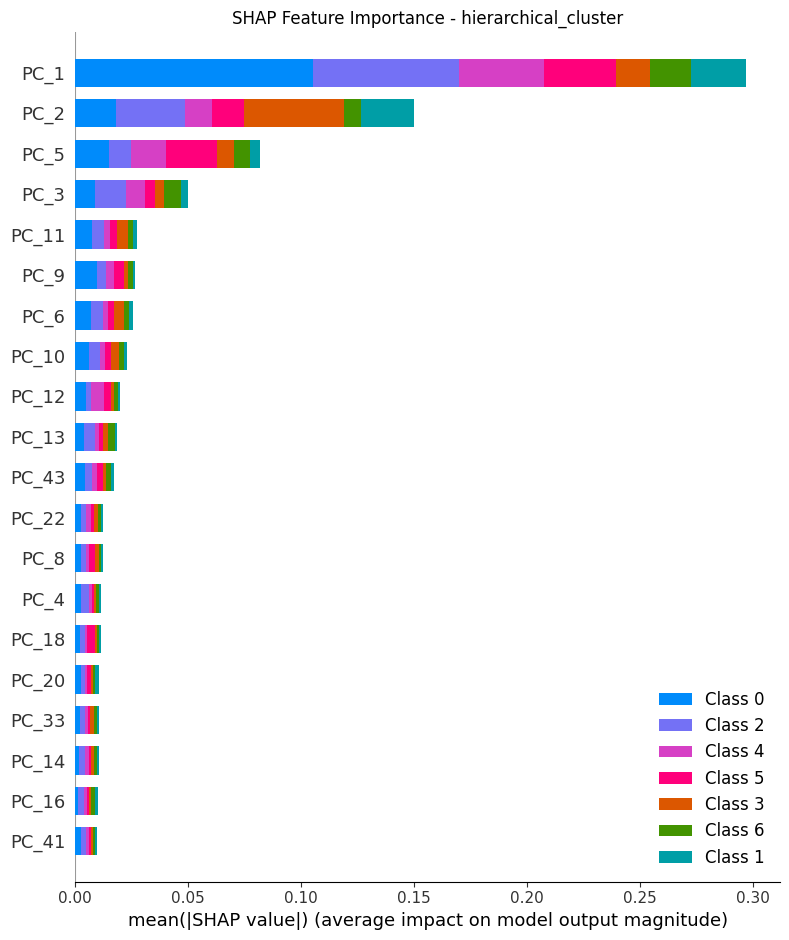

In [47]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {method}')
plt.tight_layout()
plt.show()

### SHAP Beeswarm Plot

Shows the distribution of SHAP values for each feature. Color indicates feature value (red=high, blue=low).

<Figure size 2500x1000 with 0 Axes>

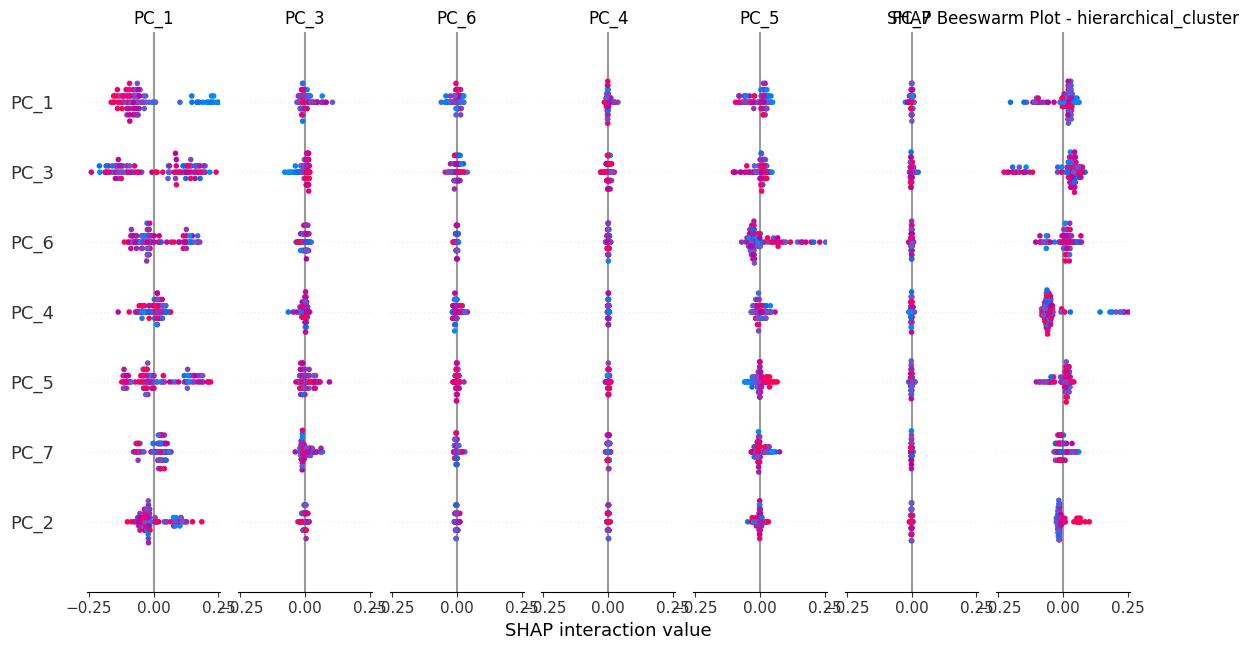

In [48]:
plt.figure(figsize=(25, 10))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.title(f'SHAP Beeswarm Plot - {method}')
plt.tight_layout()
plt.show()

## LIME Analysis - Local Interpretable Explanations

LIME explains individual predictions by approximating the model locally with an interpretable model.

In [60]:
method = random.choice(clustering_methods)
model_data = surrogate_models[method]
model = model_data['model']

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=model_data['X_train'],
    feature_names=feature_names,
    class_names=[f'Cluster_{i}' for i in range(len(np.unique(model_data['y_train'])))],
    mode='classification',
    random_state=42
)

print(f"LIME Explainer created for {method}")

LIME Explainer created for hierarchical_cluster


### Generate LIME Explanation for a Random Instance

Explains why a specific face sample was assigned to its predicted cluster.

In [61]:
sample_idx = random.randint(0, len(model_data['X_test']) - 1)
sample_instance = model_data['X_test'][sample_idx]
true_label = model_data['y_test'][sample_idx]
predicted_label = model.predict([sample_instance])[0]

lime_exp = lime_explainer.explain_instance(
    sample_instance,
    model.predict_proba,
    num_features=15,
    top_labels=1
)

### Visualize LIME Explanation

Bar chart showing which features pushed the prediction toward or away from the predicted cluster.

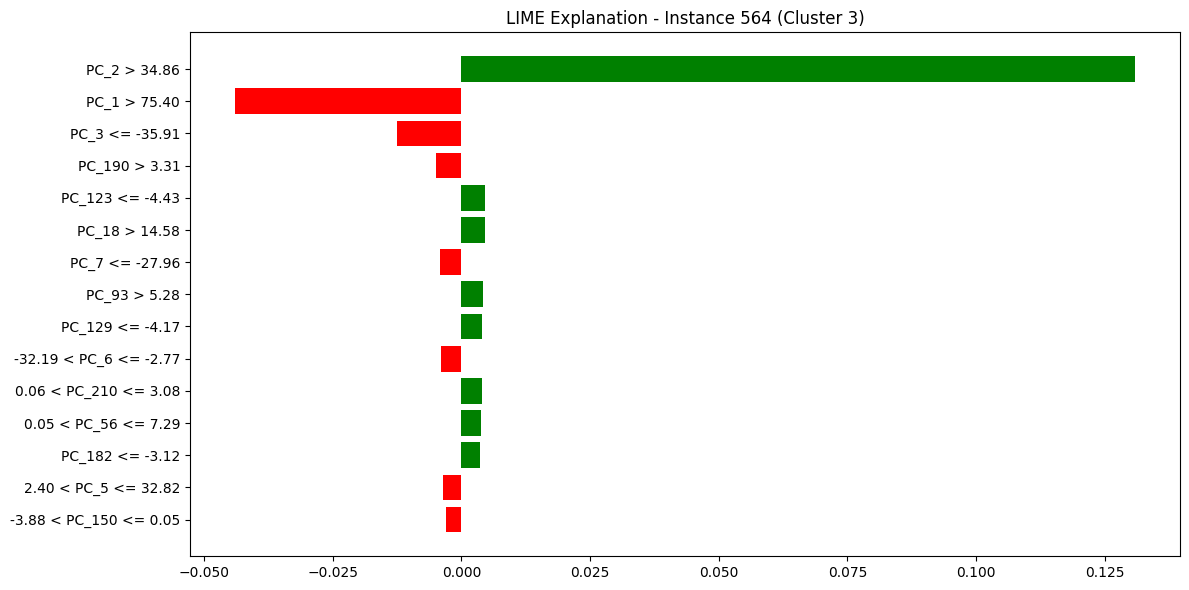

In [63]:
fig = lime_exp.as_pyplot_figure(label=predicted_label)
fig.set_size_inches(12, 6)
plt.title(f'LIME Explanation - Instance {sample_idx} (Cluster {predicted_label})')
plt.tight_layout()
plt.show()

### Aggregated LIME Feature Importance

Compute average LIME importance across multiple samples to get global-like importance from local explanations.

In [64]:
def aggregate_lime_explanations(explainer, model, X_samples, n_samples=50, n_features=10):
    feature_importance = {f: [] for f in feature_names}
    
    for i in range(min(n_samples, len(X_samples))):
        exp = explainer.explain_instance(X_samples[i], model.predict_proba, num_features=n_features)
        exp_map = dict(exp.as_list())
        
        for feature in feature_names:
            importance = 0
            for key, value in exp_map.items():
                if feature in key:
                    importance += abs(value)
            feature_importance[feature].append(importance)
    
    return {f: np.mean(v) for f, v in feature_importance.items()}

lime_importance = aggregate_lime_explanations(lime_explainer, model, model_data['X_test'][:50])

### Visualize Aggregated LIME Importance

Top 20 most important features based on aggregated LIME explanations.

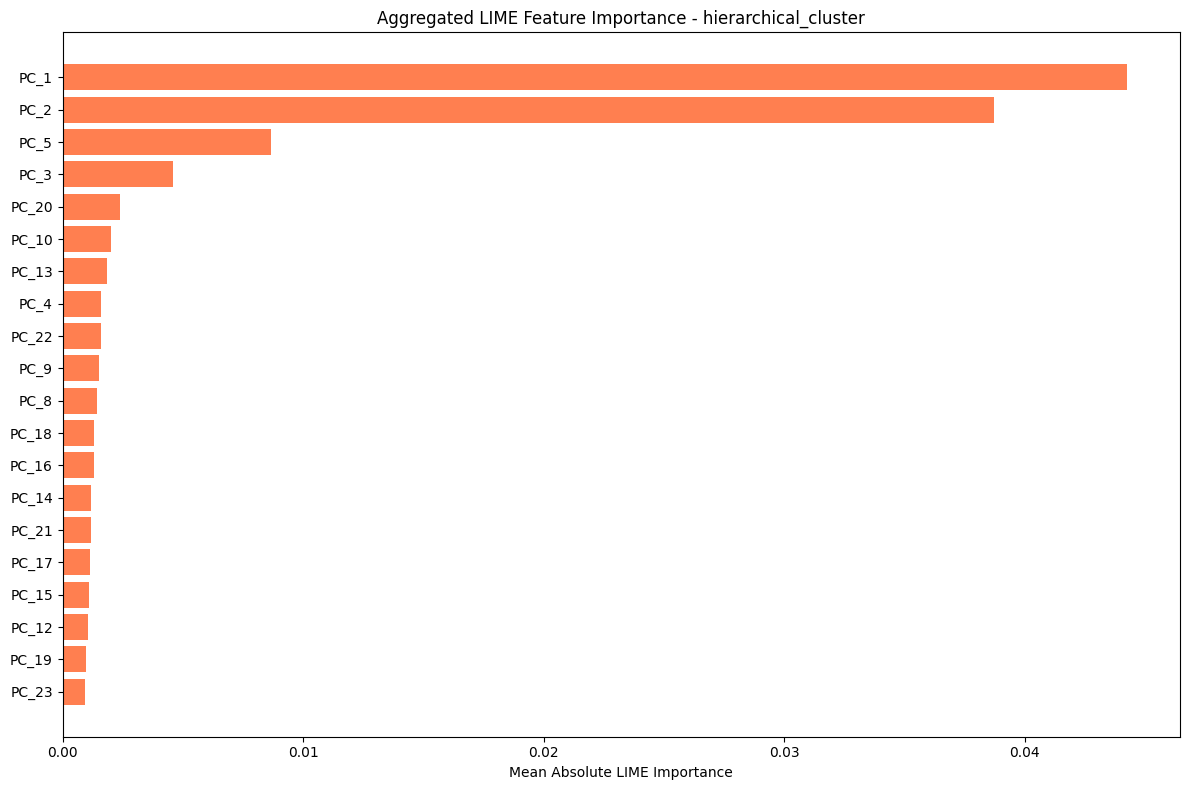

In [65]:
sorted_importance = sorted(lime_importance.items(), key=lambda x: x[1], reverse=True)[:20]
features, importances = zip(*sorted_importance)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, color='coral')
plt.yticks(range(len(features)), features)
plt.xlabel('Mean Absolute LIME Importance')
plt.title(f'Aggregated LIME Feature Importance - {method}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Feature Importance Heatmap

Compare Random Forest feature importances across all clustering methods to see which principal components are consistently important.

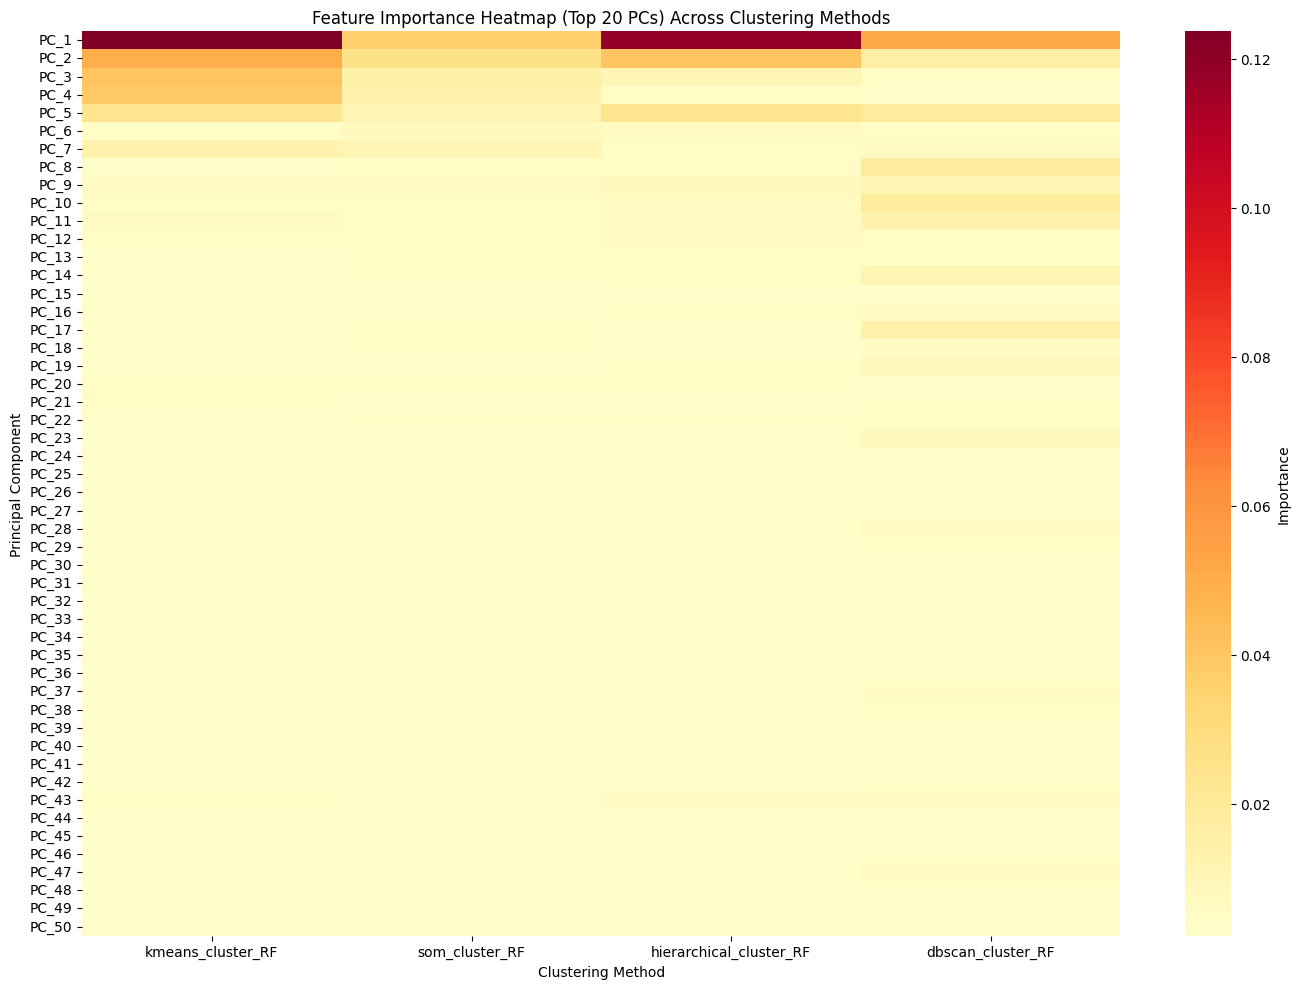

In [66]:
importance_summary = pd.DataFrame(index=feature_names[:50])

for method in clustering_methods:
    model_data = surrogate_models[method]
    model = model_data['model']
    
    rf_importance = model.feature_importances_
    importance_summary[f'{method}_RF'] = rf_importance[:50]

plt.figure(figsize=(14, 10))
import seaborn as sns
sns.heatmap(importance_summary, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap (Top 20 PCs) Across Clustering Methods')
plt.xlabel('Clustering Method')
plt.ylabel('Principal Component')
plt.tight_layout()
plt.show()

## LIME Image Prediction Function

Define a function that takes images, preprocesses them, and returns cluster predictions. This is required for LIME image explanations.

In [67]:
def predict_cluster_from_image(images):
    flattened_data = []
    TARGET_SIZE = (250, 250) 
    
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:
            if img.dtype == np.float64 or img.dtype == np.float32:
                img_uint8 = (img * 255).astype(np.uint8)
            else:
                img_uint8 = img
            
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
            
        if gray.shape != TARGET_SIZE:
            gray = cv2.resize(gray, TARGET_SIZE)
            
        flat = gray.flatten()
        flattened_data.append(flat)
    
    X_input = np.array(flattened_data)
    
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    
    target_method = 'kmeans_cluster' 
    model = surrogate_models[target_method]['model']
    
    return model.predict_proba(X_pca)

## LIME Image Explanation

Generate visual explanations showing which regions of the face image are most important for the clustering decision. The heatmap highlights areas that push toward (red) or away from (blue) the predicted cluster.

Generating LIME visual explanation for Sample 1323...


  0%|          | 0/1000 [00:00<?, ?it/s]

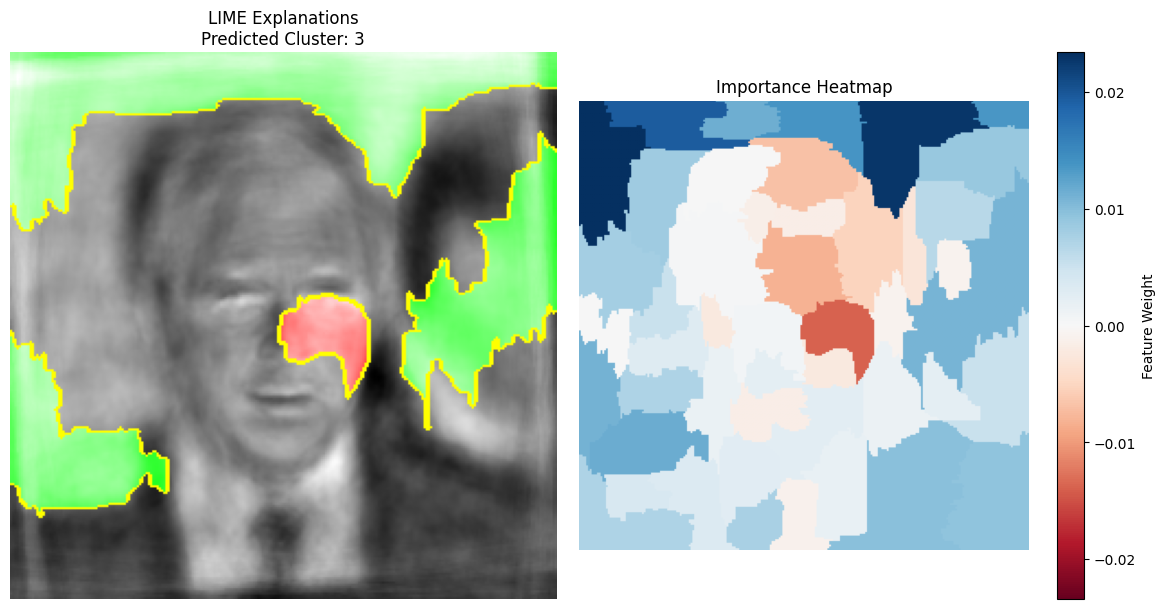

In [73]:
explainer = lime_image.LimeImageExplainer()

sample_idx = random.randint(0, len(pca_features) - 1)

pca_vec = pca_features.iloc[sample_idx].values.reshape(1, -1)

rec_img_flat = pca.inverse_transform(pca_vec) 

rec_img_small = rec_img_flat.reshape(250, 250) # Assuming PCA features are 128x128
rec_img_large = cv2.resize(rec_img_small, (250, 250))

rec_img_norm = (rec_img_large - rec_img_large.min()) / (rec_img_large.max() - rec_img_large.min())
sample_image_rgb = np.stack([rec_img_norm]*3, axis=-1)

print(f"Generating LIME visual explanation for Sample {sample_idx}...")
explanation = explainer.explain_instance(
    sample_image_rgb, 
    predict_cluster_from_image, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000 
)

target_cluster = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    target_cluster, 
    positive_only=False, 
    num_features=10, 
    hide_rest=False
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanations\nPredicted Cluster: {target_cluster}")
plt.axis('off')

plt.subplot(1, 2, 2)
ind = explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin = -np.max(np.abs(heatmap)), vmax = np.max(np.abs(heatmap)))
plt.colorbar(label='Feature Weight')
plt.title("Importance Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()

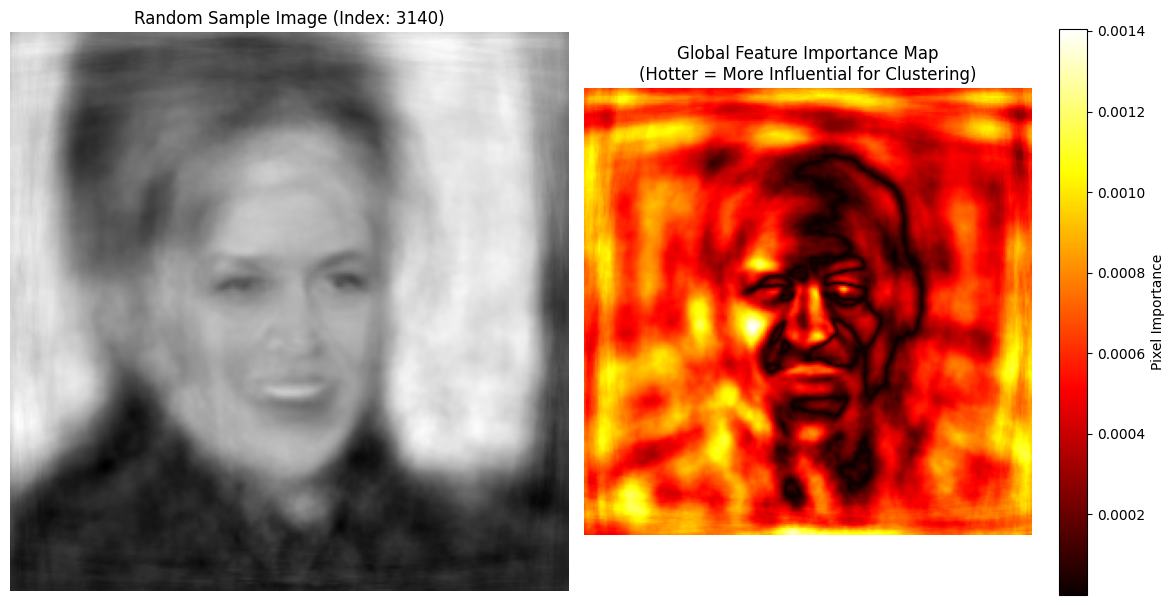

In [74]:
rf_model = surrogate_models['kmeans_cluster']['model']

importances = rf_model.feature_importances_
pixel_importance_vector = np.abs(importances @ pca.components_)
heatmap_global = pixel_importance_vector.reshape(250, 250)

random_idx = random.randint(0, len(pca_features) - 1)
pca_vec = pca_features.drop(columns=['person_name'], errors='ignore').iloc[random_idx].values.reshape(1, -1)
reconstructed_flat = scaler.inverse_transform(pca.inverse_transform(pca_vec))
random_image = reconstructed_flat.reshape(250, 250)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(random_image, cmap='gray')
plt.title(f"Random Sample Image (Index: {random_idx})")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(heatmap_global, cmap='hot')
plt.colorbar(label='Pixel Importance')
plt.title("Global Feature Importance Map\n(Hotter = More Influential for Clustering)")
plt.axis('off')
plt.tight_layout()
plt.show()